In [1]:
!pip install sparse==0.7.0
!pip install efficientnet_pytorch
!pip install scipy==1.4.1
!pip install torchio

     |████████████████████████████████| 48 kB 239 kB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=b574c48f3d57d2038eb6d4952bf82edd7930f2cc1da5b37f9d5f8fe4d1f5baa4
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 108 kB 402 kB/s eta 0:00:01
  Created wheel for Python-Deprecated: filename=Python_Deprecated-1.1.0-py2.py3-none-any.whl size=3069 sha256=2f604e48e2eb755b5c3fb4ac82b7d3fb92ef94318879cdf1f1f168abc9ee78d6
  Stored in directory: /root/.cache/pip/wheels/e2/6a/3e

In [2]:
import platform
import os
from collections import namedtuple, defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format = 'svg'

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import torchio


import numpy as np
import pandas as pd
import sparse

from efficientnet_pytorch import EfficientNet

from sklearn.model_selection import train_test_split


RUNNING_IN_KAGGLE = 'linux' in platform.platform().lower()
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/" if RUNNING_IN_KAGGLE else '/Users/Macbook/datasets/KaggleOSICPulmonaryFibrosisProgression'
PROCESSED_PATH = '../input/osic-processed/' if RUNNING_IN_KAGGLE else '/Users/Macbook/datasets/processed-data/'  # TODO: fix this line

dtype = torch.float32
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device = torch.device(device)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [3]:
meta_stats = dict.fromkeys(['Weeks', 'Percent', 'FVC'])
meta_df = pd.read_csv(f'{IMAGE_PATH}/train.csv')
for key in meta_stats:
    values = meta_df[key]
    stat = namedtuple('mean', 'std')
    stat.mean = values.mean()
    stat.std = values.std()
    meta_stats[key] = stat
stat = namedtuple('mean', 'std')
stat.mean = 971.4692260919278
stat.std = 117.84143467421829
meta_stats['Lungs'] = stat

In [4]:
meta_stats['Percent'].mean, meta_stats['Percent'].std

(77.67265350296324, 19.823261324684214)

In [5]:
class CTDataset(torch.utils.data.Dataset):
    def __init__(
            self, root, csv_path, train=True, transform=None, test_size=0.25,
            random_state=42, padding_mode=None, padding_constant=None, pad_global=False
    ):
        assert test_size is not None
        assert padding_mode in {None, 'edge', 'mean', 'max_min', 'constant'}
        assert (padding_mode == 'constant' and padding_constant is not None) or (padding_mode != 'constant')

        self.root = root
        self.train = train
        self.csv_path = csv_path
        self.test_size = test_size
        self.transform = transform

        self.random_state = random_state

        self.padding_mode = padding_mode
        self.padding_constant = padding_constant

        self.pad_global = pad_global

        if not os.path.exists(self.root):
            raise ValueError('Data is missing')

        self._patients = list(sorted(os.listdir(self.root)))

        if self.test_size == 0:
            self._train_patients, self._test_patients = self._patients, []
        else:
            self._train_patients, self._test_patients = train_test_split(
                self._patients, test_size=self.test_size, random_state=random_state
            )

        self._table_features = dict()
        table_data = pd.read_csv(self.csv_path)
        for patient in self._patients:
            patient_data = table_data[table_data.Patient == patient]

            all_percents = patient_data.Percent.tolist()
            all_weeks = patient_data.Weeks.tolist()
            all_fvcs = patient_data.FVC.tolist()

            all_percents, all_weeks, all_fvcs = zip(*sorted(zip(all_percents, all_weeks, all_fvcs), key=lambda x: x[1]))
            all_percents, all_weeks, all_fvcs = list(all_percents), list(all_weeks), list(all_fvcs)

            age = sorted(zip(*np.unique(patient_data.Age, return_counts=True)), key=lambda x: x[1])[-1][0]
            sex = sorted(zip(*np.unique(patient_data.Sex, return_counts=True)), key=lambda x: x[1])[-1][0]
            smoking_status = \
                sorted(zip(*np.unique(patient_data.SmokingStatus, return_counts=True)), key=lambda x: x[1])[-1][0]

            sex = [0, 1] if sex == 'Female' else [1, 0]
            smoking_status = (
                [1, 0, 0] if smoking_status == 'Ex-smoker' else
                [0, 1, 0] if smoking_status == 'Never smoked' else
                [0, 0, 1] if smoking_status == 'Currently smokes' else
                [0, 0, 0]
            )
            self._table_features[patient] = (
                all_percents, all_weeks, all_fvcs, [age] + sex + smoking_status
            )

    def __getitem__(self, index, transform=None):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        transform = transform if transform is not None else self.transform

        patient = self._train_patients[index] if self.train else self._test_patients[index]
        base_path = os.path.join(self.root, patient)

        # noinspection PyTypeChecker
        meta = np.load(os.path.join(base_path, 'meta.npy'), allow_pickle=True).tolist()  # type: Dict[List]
        masks = sparse.load_npz(os.path.join(base_path, 'masks.npz'))
        images = np.load(os.path.join(base_path, 'images.npy'))

        meta_processed = dict()
        for key, values in meta.items():
            if key in {'SliceLocation', 'InstanceNumber'}:
                continue
            else:
                unique_values, values_cnt = np.unique(values, return_counts=True, axis=0)
                most_frequent = sorted(zip(unique_values, values_cnt), key=lambda x: x[1])[-1][0]
                most_frequent = np.array(most_frequent).reshape(-1)
                if key in {
                    'SliceThickness', 'TableHeight', 'WindowCenter', 'WindowWidth'
                }:
                    meta_processed[key] = most_frequent[0]
                elif key == 'PixelSpacing':
                    if len(most_frequent) == 1:
                        meta_processed['PixelSpacingX'], meta_processed['PixelSpacingY'] = (
                            most_frequent[0], most_frequent[0]
                        )
                    else:
                        meta_processed['PixelSpacingX'], meta_processed['PixelSpacingY'] = (
                            most_frequent[0], most_frequent[1]
                        )
                elif key == 'PatientPosition':
                    pass
                elif key == 'PositionReferenceIndicator':
                    pass

        all_percents, all_weeks, all_fvcs, features = self._table_features[patient]
        features = torch.tensor([value for key, value in meta_processed.items()] + features)

        # weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
        # fvsc_mean, fvsc_std = 2690.479018721756, 832.5021066817238

        features_mean, features_std = (
            torch.tensor([
                2.76561876e+00, 1.42373805e+00, 1.25608294e+00, 1.33766080e+02,
                -5.23857955e+02, -1.24154545e+03, 6.72613636e+01, 7.89772727e-01,
                2.10227273e-01, 6.70454545e-01, 2.78409091e-01, 5.11363636e-02
            ]),
            torch.tensor([
                2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
                1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
                4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
            ])
        )
        features = (features - features_mean) / features_std

        if self.padding_mode is None:
            pass
        if self.padding_mode == 'edge':
            all_weeks = [-13] + all_weeks + [133]
            all_fvcs = [all_fvcs[0]] + all_fvcs + [all_fvcs[1]]
            all_percents = [all_percents[0]] + all_percents + [all_percents[1]]
        if self.padding_mode == 'mean':
            all_weeks = [-13] + all_weeks + [133]
            all_fvcs = [np.mean(all_fvcs)] + all_fvcs + [np.mean(all_fvcs)]
            all_percents = [np.mean(all_percents)] + all_percents + [np.mean(all_percents)]
        if self.padding_mode == 'max_min':
            all_weeks = [-13] + all_weeks + [133]
            all_fvcs = [np.max(all_fvcs)] + all_fvcs + [np.min(all_fvcs)]
            all_percents = [np.max(all_percents)] + all_percents + [np.min(all_percents)]
        if self.padding_mode == 'constant':
            all_weeks = [-13] + all_weeks + [133]
            all_fvcs = [self.padding_constant] + all_fvcs + [self.padding_constant]
            all_percents = [self.padding_constant] + all_percents + [self.padding_constant]

        if self.pad_global:
            n_measures = len(all_weeks)
            all_fvcs = torch.tensor(all_fvcs + [-100] * (200 - n_measures))
            all_weeks = torch.tensor(all_weeks + [-100] * (200 - n_measures))
            all_percents = torch.tensor(all_percents + [-100] * (200 - n_measures))
        else:
            all_fvcs = torch.tensor(all_fvcs)
            all_weeks = torch.tensor(all_weeks)
            all_percents = torch.tensor(all_percents)

        images = torch.tensor(images[None, :, :, :])
        masks = torch.tensor(masks[None, :, :, :].todense())

        if transform is not None:
            # noinspection PyTypeChecker
            subject = torchio.Subject(
                masks=torchio.ScalarImage(tensor=masks),
                images=torchio.ScalarImage(tensor=images)
            )
            transformed_subject = transform(subject)
            masks = transformed_subject.masks.tensor
            images = transformed_subject.images.tensor

        return all_percents, all_weeks, all_fvcs, features, masks, images

    def __len__(self):
        return len(self._train_patients if self.train else self._test_patients)

    def __repr__(self):
        fmt_str = 'OSIC Pulmonary Fibrosis Progression Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        return fmt_str

In [6]:
transforms = torchio.transforms.Compose([
    torchio.transforms.RandomAffine(degrees=(10, 10),
                                    translation=(-10, -10), 
                                    isotropic=False, 
                                    default_pad_value='minimum', 
                                    image_interpolation='linear')])

In [7]:
train_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
       train=True, transform=transforms, test_size=0.25, random_state=42, padding_mode=None, padding_constant=None
)

val_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=False, test_size=0.25, transform=None, random_state=42, padding_mode=None, padding_constant=None
)

In [8]:
len(train_dataset), len(val_dataset)

(132, 44)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=3)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=3)

In [10]:
def laplace_loss(y_true, y_pred, log_sigma):
    log_sigma = torch.clamp(log_sigma, -np.log(70), np.log(70))
    losses = np.sqrt(2) * (y_true - y_pred).abs() / log_sigma.exp() + log_sigma + np.log(2) / 2
    return losses.mean()

In [11]:
def mse_loss(y_true, y_pred, log_sigma):
    losses = (y_true - y_pred)**2 + (log_sigma - np.log(70))**2
    return losses.mean()

In [12]:
class Net2D_1(nn.Module):
    
    def __init__(self, feature_values, pred_values):
        super(Net2D_1, self).__init__()
        
        self.efficient_net_1 = EfficientNet.from_pretrained('efficientnet-b0', in_channels=1)
        self.batch_norm = nn.BatchNorm2d(num_features=1280)
        self.efficient_net_2 = EfficientNet.from_pretrained('efficientnet-b0', in_channels=1280)

        self.fc_1 = nn.Linear(1280 + feature_values, 500)
        self.fc_2 = nn.Linear(500, 250)
        self.fc_3 = nn.Linear(250, pred_values)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, X, meta_X):
        """
        X: tensor (s, h, w): s - slices
        meta_X: tensor (n, 12)
        """
        
        X = X[::3, :, :]
        X = X.unsqueeze(1)
        X = self.efficient_net_1.extract_features(X)
        
        X = X.view(X.shape[0], 1280, 64) # shape (s, 1280, 64)
        
        X = X.unsqueeze(0) # shape (1, s, 1280, 64)
        X = X.transpose(1, 2) # shape (1,  1280, s, 64)
        
        X = self.batch_norm(X)
        
        X = self.efficient_net_2.extract_features(X) # shape (1, 1280, 2, 2)
        X = torch.mean(X, dim=(2,3)) # shape (1, 1280)
#       X = X.view(1, 5120)
        
        X = torch.cat([X.repeat(meta_X.shape[0], 1), meta_X], dim=1) 
        
        X = F.relu(self.fc_1(X))
        X = F.relu(self.fc_2(X))
        y = self.fc_3(X)
        
        return y

In [13]:
class Net2D_2(nn.Module):
    
    def __init__(self, feature_values, pred_values):
        super(Net2D_2, self).__init__()
        
        self.efficient_net_1 = EfficientNet.from_pretrained('efficientnet-b0', in_channels=1)
        self.batch_norm_1 = nn.BatchNorm2d(num_features=1280)
        self.conv_1 = nn.Conv2d(1280, 640, 3, 3)
        self.batch_norm_2 = nn.BatchNorm2d(num_features=640)
        self.conv_2 = nn.Conv2d(640, 320, 3, 3)
        self.batch_norm_3 = nn.BatchNorm2d(num_features=320)
        self.conv_3 = nn.Conv2d(320, 320, 3, 3)
        self.batch_norm_4 = nn.BatchNorm2d(num_features=320)

        self.fc_1 = nn.Linear(1280 + feature_values, 500)
        self.fc_2 = nn.Linear(500, 250)
        self.fc_3 = nn.Linear(250, pred_values)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, X, meta_X):
        """
        X: tensor (s, h, w): s - slices
        meta_X: tensor (n, 12)
        """
        
        X = X[::3, :, :]
        X = X.unsqueeze(1)
        X = self.efficient_net_1.extract_features(X)
        
        X = X.view(X.shape[0], 1280, 64) # shape (s, 1280, 64)
        
        X = X.unsqueeze(0) # shape (1, s, 1280, 64)
        X = X.transpose(1, 2) # shape (1,  1280, s, 64)
        
        X = self.batch_norm_1(X)
        
        X = self.conv_1(X)
        X = self.batch_norm_2(X)
        X = F.relu(X)
        X = self.conv_2(X)
        X = self.batch_norm_3(X)
        X = F.relu(X)
        X = self.conv_3(X)
        X = self.batch_norm_4(X)
        X = F.relu(X)
       
        X = X.view(1,-1)
        
        X = torch.cat([X.repeat(meta_X.shape[0], 1), meta_X], dim=1) 
        
        X = F.relu(self.fc_1(X))
        X = F.relu(self.fc_2(X))
        y = self.fc_3(X)
        
        return y

In [14]:
def polynom(coords, coefs):
    # coords shape (n, )
    # coefs shape (4, )
    
    poly_coords = torch.empty((coords.shape[0], 4), dtype=dtype, device=device)
    poly_coords[:, 3] = 1
    poly_coords[:, 2] = coords
    poly_coords[:, 1] = coords**2
    poly_coords[:, 0] = coords**3
    return (poly_coords * coefs.unsqueeze(0)).sum(dim=1)

In [15]:
def train_polynom(model, optimizer, loss_func, train_dataset, val_dataset, epochs, scheduler=None):

    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

    val_loss_min = np.inf
    for epoch in range(epochs):
        running_loss = 0.0
        
#         for iter_num, data in enumerate(train_dataset):
        data = train_dataset[0]
        iter_num = 0
        model.train()
        optimizer.zero_grad()

        #prepare lungs
        masks = data.masks 
        images = data.images

        lungs = -1000 * (1.0 - masks) + masks * images
        lungs = (lungs - meta_stats['Lungs'].mean) / meta_stats['Lungs'].std
        
        lungs = lungs.squeeze(0)
        X = lungs.to(device)

        # prepare features
        weeks = torch.tensor(data.weeks, dtype=dtype, device=device)
        fvcs = torch.tensor(data.fvcs, dtype=dtype, device=device)
        features = torch.tensor(data.features, dtype=dtype, device=device)
        num_weeks = len(weeks)
        meta_weeks = (weeks - meta_stats['Weeks'].mean) / meta_stats['Weeks'].std
        meta_fvcs = (fvcs - meta_stats['FVC'].mean) / meta_stats['FVC'].std
        
        meta_X = torch.cat([meta_weeks.unsqueeze(1), meta_fvcs.unsqueeze(1), 
                               features.unsqueeze(0).repeat(num_weeks, 1)], dim=1)
        
        preds = model(X, meta_X) # shape (num_weeks, 5)


        coefs = preds[:, 0:4]
        log_sigma = preds[:, 4]

        loss = 0.0
        lap_loss = 0.0
        for week in range(num_weeks):
            fvcs_pred = polynom(weeks, coefs[week])
            loss += loss_func(fvcs, fvcs_pred, log_sigma[week])
            lap_loss += laplace_loss(fvcs.detach(), fvcs_pred.detach(), log_sigma[week].detach())

        loss /= num_weeks
        lap_loss /= num_weeks
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()

        print("Epoch: {} ".format(epoch + 1),
              "Iteration: {} ".format(iter_num),
              "lr: {:.6f} ".format(get_lr(optimizer)),
              "Loss: {:.6f}.".format(loss.item()),
              'Laplace loss: {:.6f}.'.format(lap_loss.item()),
               "Sigma: {:.6f}".format(log_sigma.mean().item()))

    running_loss /= len(train_dataset)  
        
#         val_loss = eval_model(model, loss_func, val_dataset)
    
        
#         print("Epoch: {}/{}...".format(epoch + 1, n_epochs),
#               "lr: {:.6f}...".format(get_lr(optimizer)),
#               "Loss: {:.6f}...".format(running_loss.item()),
#               "Val Loss: {:.6f}".format(val_loss))
#         print('------------------------------')

        
#         if val_loss <= val_loss_min:
#             torch.save(model.state_dict(), f'./state_dict{epoch}.pt')
#             print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
#             val_loss_min = val_loss
        
#         if scheduler is not None:
#             scheduler.step()

In [16]:
all_percents, all_weeks, all_fvcs, features, masks, images = train_dataset[0]

In [17]:
all_percents.dtype, all_weeks.dtype, all_fvcs.dtype, features.dtype, masks.dtype, images.dtype 

(torch.float32,
 torch.int64,
 torch.int64,
 torch.float64,
 torch.float32,
 torch.float32)

In [18]:
print(all_percents.shape, all_weeks.shape, all_fvcs.shape, features.shape, masks.shape, images.shape)

torch.Size([9]) torch.Size([9]) torch.Size([9]) torch.Size([12]) torch.Size([1, 192, 256, 256]) torch.Size([1, 192, 256, 256])


In [25]:
def train_fvc(model, optimizer, loss_func, train_dataset, val_dataset, epochs, scheduler=None):

    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

    val_loss_min = np.inf
    for epoch in range(epochs):
        
#        for iter_num, data in enumerate(train_dataset):
            data = train_dataset[0]
            iter_num = 0
            model.train()
            optimizer.zero_grad()

            #prepare lungs
            all_percents, all_weeks, all_fvcs, features, masks, images = data
            
            lungs = -1000 * (1.0 - masks) + masks * images
            lungs = (lungs - meta_stats['Lungs'].mean) / meta_stats['Lungs'].std

            lungs = lungs.squeeze(0)
            X = lungs.float().to(device)

            num_weeks = all_weeks.shape[0]

            meta_weeks = (all_weeks - meta_stats['Weeks'].mean) / meta_stats['Weeks'].std
            meta_fvcs = (all_fvcs - meta_stats['FVC'].mean) / meta_stats['FVC'].std
            meta_percents = (all_percents - meta_stats['Percent'].mean) / meta_stats['Percent'].std
            
            meta_weeks = meta_weeks.float().to(device)
            meta_fvcs = meta_fvcs.float().to(device)
            meta_percents = meta_percents.float().to(device)
            features = features.float().to(device)
            all_fvcs = all_fvcs.float().to(device)
            
            lap_loss = 0.0
            running_loss = 0.0
            for week in range(num_weeks):
                meta_X = torch.cat([(meta_weeks - meta_weeks[week]).unsqueeze(1), 
                                    meta_percents[week].repeat(num_weeks,1),
                                    meta_weeks[week].repeat(num_weeks,1),
                                    meta_fvcs[week].repeat(num_weeks,1), 
                                   features.unsqueeze(0).repeat(num_weeks, 1)], dim=1)
    
                preds = model(X, meta_X) # shape (num_weeks, 2)
                fvcs_pred = preds[:, 0]
                log_sigma = preds[:, 1]
                loss = loss_func(all_fvcs, fvcs_pred, log_sigma)
                loss.backward() 
                optimizer.step()
                
                for param in model.fc_3.parameters():
                    print(param.grad)
                for param in model.fc_2.parameters():
                    print(param.grad)
                for param in model.fc_1.parameters():
                    print(param.grad)   
                
                running_loss += loss.item()
                with torch.no_grad():
                    lap_loss += laplace_loss(all_fvcs, fvcs_pred, log_sigma).item()

            running_loss /= num_weeks
            lap_loss /= num_weeks

            print("Epoch: {} ".format(epoch + 1),
                  "Iteration: {} ".format(iter_num),
                  "lr: {:.6f} ".format(get_lr(optimizer)),
                  "Loss: {:.6f}.".format(running_loss),
                  'Laplace loss: {:.6f}.'.format(lap_loss),
                   "Sigma: {:.6f}".format(torch.clamp(log_sigma.mean(), -np.log(70), np.log(70)).item()))
            if scheduler is not None:
                scheduler.step()

In [26]:
model = Net2D_1(feature_values=16, pred_values=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, 10, gamma=0.1, last_epoch=-1)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


In [27]:
train_fvc(model, optimizer, laplace_loss, train_dataset, val_dataset, epochs=50, scheduler=scheduler)

TypeError: 'Tensor' object is not callable

In [ ]:
model = Net2D_2(feature_values=16, pred_values=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_polynom(model, optimizer, laplace_loss, train_dataset, val_dataset, epochs=50, scheduler=None)

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] /= 10

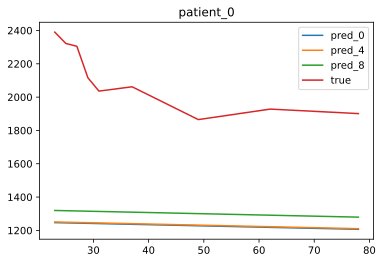

In [22]:
# for i, data in enumerate(train_dataset):
data = train_dataset[0]
i=0
model.eval()

all_percents, all_weeks, all_fvcs, features, masks, images = data

lungs = -1000 * (1.0 - masks) + masks * images
lungs = (lungs - meta_stats['Lungs'].mean) / meta_stats['Lungs'].std

lungs = lungs.squeeze(0)
X = lungs.float().to(device)

num_weeks = all_weeks.shape[0]

meta_weeks = (all_weeks - meta_stats['Weeks'].mean) / meta_stats['Weeks'].std
meta_fvcs = (all_fvcs - meta_stats['FVC'].mean) / meta_stats['FVC'].std
meta_percents = (all_percents - meta_stats['Percent'].mean) / meta_stats['FVC'].std

meta_weeks = meta_weeks.float().to(device)
meta_fvcs = meta_fvcs.float().to(device)
meta_percents = meta_percents.float().to(device)
features = features.float().to(device)
all_fvcs = all_fvcs.float().to(device)
            
plt.figure()
plt.title('patient_'+str(i))
for week in [0, num_weeks//2, num_weeks - 1]:
    meta_X = torch.cat([(meta_weeks - meta_weeks[week]).unsqueeze(1), 
                        meta_percents[week].repeat(num_weeks,1),
                        meta_weeks[week].repeat(num_weeks,1),
                        meta_fvcs[week].repeat(num_weeks,1), 
                       features.unsqueeze(0).repeat(num_weeks, 1)], dim=1)
    preds = model(X, meta_X) # shape (num_weeks, 2)
    fvcs_pred = preds[:, 0]
    log_sigma = preds[:, 1]
    plt.plot(all_weeks.numpy(), fvcs_pred.detach().cpu().numpy(), label='pred_'+str(week))
plt.plot(all_weeks.numpy(), all_fvcs.cpu().numpy(), label='true')
plt.legend()
plt.show()

In [27]:
list(model.fc_3.parameters())

[Parameter containing:
 tensor([[-1.1327e-02,  6.0482e-03,  5.6350e-04,  2.4434e-03,  1.7578e-01,
           1.8138e-01,  1.9569e-01, -5.4831e-03,  1.8435e-01, -9.8926e-03,
           1.7860e-01,  1.7924e-01,  2.3267e-02, -4.1143e-02, -1.7549e-03,
           5.8908e-02,  1.5406e-01, -3.9014e-02,  1.9127e-01, -7.2403e-03,
           1.4934e-01,  1.7120e-02,  1.7246e-01,  4.9184e-02,  1.0191e-01,
           1.7895e-01, -1.2343e-02,  3.9927e-02, -5.2059e-03,  1.5238e-01,
           6.3552e-03,  8.5475e-02,  1.6143e-03,  1.1415e-03,  9.2141e-02,
           1.6623e-01, -6.1897e-03,  1.5657e-01,  1.0445e-02,  1.9045e-01,
           1.9162e-01,  1.2809e-02,  1.9698e-01,  4.9430e-02,  1.8715e-01,
           1.7513e-01, -2.0496e-03,  1.8891e-01,  1.6594e-01,  1.8728e-01,
           2.4871e-03,  2.0187e-02,  1.8579e-01,  5.4985e-02,  1.6461e-01,
           1.8635e-01,  1.1618e-02,  4.3038e-03, -1.1816e-02,  1.9511e-01,
           1.6515e-01, -2.1973e-02,  4.4783e-02, -4.0047e-03,  1.0629e-01,
  